# 安裝需要的套件

In [ ]:
!pip install torch torchvision matplotlib

# Step 1: 下載和準備資料

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
# 下載並準備 CIFAR10 資料集
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# Step 2: 定義教師模型與學生模型

In [ ]:
import torchvision.models as models
import torch.nn as nn

# 定義教師模型（較大型的模型）
teacher_model = models.resnet18(pretrained=True)
teacher_model.fc = nn.Linear(512, 10)  # 修改最後一層以適應 CIFAR10
teacher_model = teacher_model.to('cuda')

# 定義學生模型（較小的模型）
student_model = models.resnet18(pretrained=False)
student_model.layer4 = nn.Identity()  # 移除部分層使模型變小
student_model.fc = nn.Linear(256, 10)  # 修改最後一層以適應 CIFAR10
student_model = student_model.to('cuda')


# Step 3: 定義 Knowledge Distillation 過程

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
# 設定教師模型的 fine-tuning 超參數
fine_tune_epochs = 5
fine_tune_lr = 0.001

# 為教師模型設定優化器
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=fine_tune_lr, momentum=0.9)

# 教師模型的 fine-tuning 訓練函數
def fine_tune_teacher(model, epochs=fine_tune_epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Teacher Fine-tuning Epoch {epoch + 1}/{epochs}', unit='batch'):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            teacher_optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            teacher_optimizer.step()

            running_loss += loss.item()
        print(f'Teacher Fine-tuning Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

# 執行教師模型的 fine-tuning
fine_tune_teacher(teacher_model)

Teacher Fine-tuning Epoch 1/5:   0%|          | 0/782 [00:00<?, ?batch/s]

Teacher Fine-tuning Epoch 1, Loss: 1.0437518156626646


Teacher Fine-tuning Epoch 2/5:   0%|          | 0/782 [00:00<?, ?batch/s]

Teacher Fine-tuning Epoch 2, Loss: 0.6328756300460957


Teacher Fine-tuning Epoch 3/5:   0%|          | 0/782 [00:00<?, ?batch/s]

Teacher Fine-tuning Epoch 3, Loss: 0.48094946283208745


Teacher Fine-tuning Epoch 4/5:   0%|          | 0/782 [00:00<?, ?batch/s]

Teacher Fine-tuning Epoch 4, Loss: 0.36805334045072957


Teacher Fine-tuning Epoch 5/5:   0%|          | 0/782 [00:00<?, ?batch/s]

Teacher Fine-tuning Epoch 5, Loss: 0.27933248546917727


In [ ]:
# 設定 Knowledge Distillation 超參數
temperature = 4.0
alpha = 0.5  # 控制真實標籤與教師模型的知識比例
kd_lr = 0.001

# 為學生模型設定優化器
optimizer = optim.SGD(student_model.parameters(), lr=kd_lr, momentum=0.9)

# Knowledge Distillation 訓練函數
def train_kd(student_model, teacher_model, epochs=10):
    student_model.train()
    teacher_model.eval()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            # 教師模型的預測
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            # 學生模型的預測
            student_outputs = student_model(inputs)

            # 計算蒸餾損失
            loss_soft = F.kl_div(F.log_softmax(student_outputs / temperature, dim=1),
                                 F.softmax(teacher_outputs / temperature, dim=1),
                                 reduction='batchmean') * (temperature ** 2)
            loss_hard = criterion(student_outputs, labels)
            loss = alpha * loss_hard + (1 - alpha) * loss_soft

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

train_kd(student_model, teacher_model)

Epoch 1/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 1, Loss: 3.8029466797323788


Epoch 2/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 2, Loss: 2.4669534865852514


Epoch 3/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 3, Loss: 1.940208773021503


Epoch 4/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 4, Loss: 1.6193931284158125


Epoch 5/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 5, Loss: 1.4061959554319796


Epoch 6/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 6, Loss: 1.2265893620298343


Epoch 7/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 7, Loss: 1.0749869555463571


Epoch 8/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 8, Loss: 0.945838275849057


Epoch 9/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 9, Loss: 0.8350304275598672


Epoch 10/10:   0%|          | 0/782 [00:00<?, ?batch/s]

Epoch 10, Loss: 0.7408228479230495


# Step 4: 評估模型

In [ ]:
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy

# 評估教師模型與學生模型的準確度
print("Teacher Model Performance:")
teacher_accuracy = evaluate(teacher_model)

print("Student Model Performance after Distillation:")
student_accuracy = evaluate(student_model)

Teacher Model Performance:
Accuracy: 80.17%
Student Model Performance after Distillation:
Accuracy: 73.74%


# Step 5: 可視化結果比較

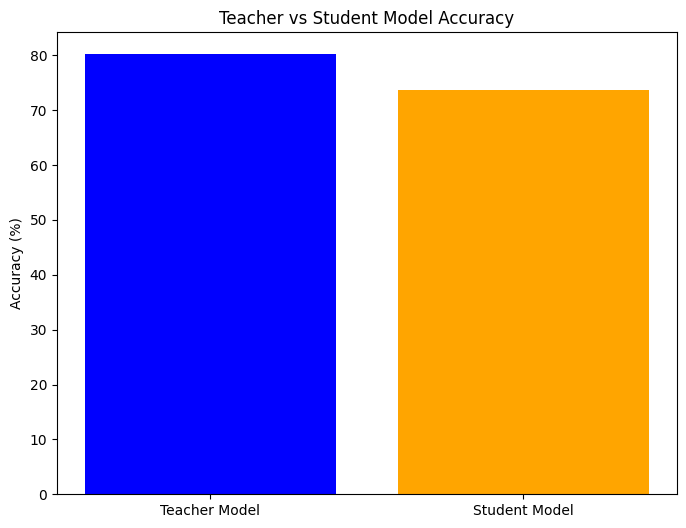

In [ ]:
# 視覺化比較
plt.figure(figsize=(8, 6))
plt.bar(['Teacher Model', 'Student Model'], [teacher_accuracy * 100, student_accuracy * 100], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.title('Teacher vs Student Model Accuracy')
plt.show()

# Step 6: 模型參數量比較

Teacher Model Parameters: 11181642
Student Model Parameters: 2785354
Compression Ratio: 4.01


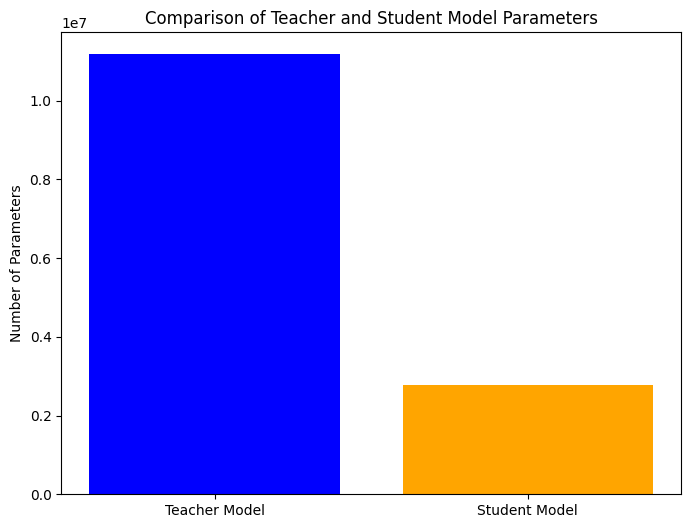

In [ ]:
# 計算模型參數量的函數
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 計算教師模型和學生模型的參數量
teacher_params = count_parameters(teacher_model)
student_params = count_parameters(student_model)

# 計算參數壓縮比例
compression_ratio = teacher_params / student_params

print(f'Teacher Model Parameters: {teacher_params}')
print(f'Student Model Parameters: {student_params}')
print(f'Compression Ratio: {compression_ratio:.2f}')

"""# Step 7: 可視化參數量比較"""

# 視覺化教師模型與學生模型的參數量
plt.figure(figsize=(8, 6))
plt.bar(['Teacher Model', 'Student Model'], [teacher_params, student_params], color=['blue', 'orange'])
plt.ylabel('Number of Parameters')
plt.title('Comparison of Teacher and Student Model Parameters')
plt.show()